# Question 7


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import copy
from ipynb.fs.defs.funct import showImages, im2col

# 1. Cross Bilateral Filter
> The range filter is calculated using first image and the product of domain and range kernel is applied on second image.

In [2]:
def biLatFilt(img1, img2, win_s, sig_r, sig_d):
    ws = np.uint8(win_s/2)
    x = np.linspace(-ws, ws, 2*ws + 1)
    y = np.linspace(-ws, ws, 2*ws + 1)
    xm, ym = np.meshgrid(x, y)
    xm = np.multiply(xm, xm)
    ym = np.multiply(ym, ym)
    zm = xm + ym
    dom_filt = np.exp(zm/(-2*(sig_d**2)))
    r, c = img1.shape
    
    x1 = int((win_s - 1)/2)
    y1 = int((win_s - 1)/2)
    x1 = max(x1, 0)
    y1 = max(y1, 0)
    mat1 = np.zeros((r+win_s-1,c+win_s-1))
    mat2 = np.zeros((r+win_s-1,c+win_s-1))
    mat1[x1:x1+r, y1:y1+c] = img1
    mat2[x1:x1+r, y1:y1+c] = img2
    
    gt = im2col(np.uint8(mat1), (win_s, win_s))
    gt2 = im2col(np.uint8(mat2), (win_s, win_s))
    bt = gt - gt[ws,:]
    bt = -np.multiply(bt, bt)/(2*(sig_r**2))
    ran_filt = np.exp(bt)
    dom_filt = dom_filt.reshape(dom_filt.shape[0]*dom_filt.shape[1],1)
    bil_filt = np.multiply(dom_filt, ran_filt)
    sm = np.sum(bil_filt, axis = 0)
    out = np.sum(np.multiply(bil_filt, gt2), axis = 0)
    out = np.divide(out, sm)
    out = out.reshape(img1.shape)
    
    return out

In [3]:
def crossBilat(im1, im2, ws, sig_r, sig_d):
    out = copy.deepcopy(im1)
    for i in range(im1.shape[2]):
        out[:,:,i] = biLatFilt(im1[:,:,i], im2[:,:,i], ws, sig_r, sig_d)
    return np.uint8(out)

In [4]:
img1 = cv2.imread('./res/pots_flash.jpg')
img2 = cv2.imread('./res/pots_no_flash.jpg')
img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2RGB)

ws = 9
sig_r = 75
sig_d = 75
out = crossBilat(np.float32(img1), np.float32(img2), ws, sig_r, sig_d)

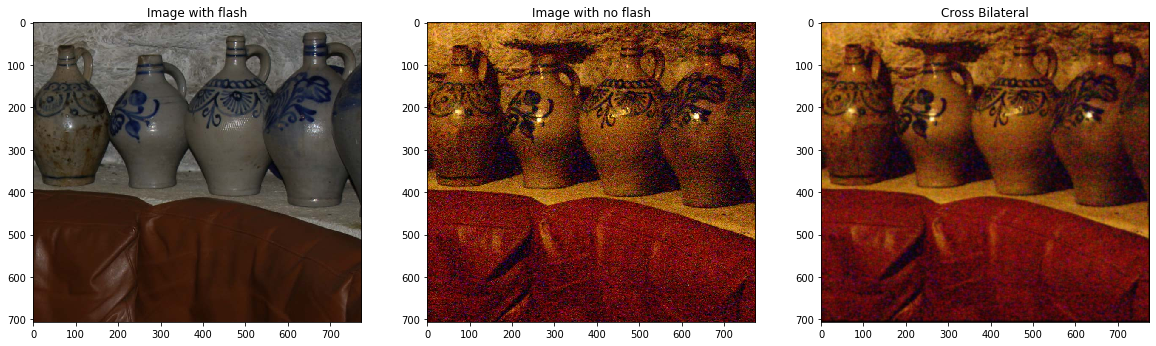

In [5]:
arr = plt.subplots(1, 3, figsize =(20,20))[1]
arr[0].imshow(img1)
arr[0].set_title('Image with flash')
arr[1].imshow(img2)
arr[1].set_title('Image with no flash')
arr[2].imshow(out)
arr[2].set_title('Cross Bilateral')
plt.show()

# 2. Inverse Bilateral Filter :-

> Inverse bilateral filter helps to blur the images, but preserve the shading.<br>
In the proposed algorithm, the following changes are made in the range filter -
>>  While calculating the range filter, negative of squared difference in intensities is taken, which is the similarity between 2 intensity values.<br>
>>The range filter here is generated by taking contrast. More weight is given when the contrast is higher as value of filter will be greater.
>><br> <center> $Similarity = - |I_1 - I_2|^2 $    <br></center> 
>><br> <center> $Contrast =- [L^2 - |I_1 - I_2|^2]$ <br></center>
>><br> <center> $F_r = e^ {\frac{Contrast}{2\sigma^2}}$ <br></center>
>><br> Explanation : If the Bilateral filter is at the top of an edge, the range filter will give very less response to the top of the step and high response to the bottom. But the contrast of top region with bottom will be large which will give more weight to the top pixel. This would lead to the gaussian blurring of the edge.
   